### Iowa State Liquor Sale Projection

The goal for this task was to provide a projection of liquor sales in the state of Iowa based on a dataset of sales of liquor from distributors to individual stores.

The data provided was the item that was sold, the date it was sold, the location of the store, the quantity of what was sold, the price per item from distributor to store, and then the retail price of the item.

First, I need to import all necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.grid_search import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

The next step is to read in the data and do any necessary cleaning. This data required a large amount of cleaning and imputing missing data. 

Also of note was that this was all completed on a dataset that was 10 percent of the original data - 30,000 records instead of 300,000. The projections will later be run on the full data, but the model will be built on the smaller set.

In [4]:
## Load the data into a DataFrame

df_10 = pd.read_csv('/Users/jcarr/Documents/GA/Data/Iowa_Liquor_sales_sample_10pct.csv')

## Transform the data

df_10["Date"] = pd.to_datetime(df_10["Date"])
df_10['quarter'] = df_10.Date.apply(lambda x: x.quarter)
df_10['month'] = df_10.Date.apply(lambda x: x.month)
df_10['year'] = df_10.Date.apply(lambda x: x.year)

df_10.rename(columns=lambda x: x.replace(' ','_'), inplace=True)
df_10.rename(columns=lambda x: x.replace('(',''), inplace=True)
df_10.rename(columns=lambda x: x.replace(')',''), inplace=True)

# Get dollar amounts into usable floats

df_10['State_Bottle_Cost'] = df_10['State_Bottle_Cost'].replace( '[\$,]','', regex=True).astype(float)
df_10['State_Bottle_Retail'] = df_10['State_Bottle_Retail'].replace( '[\$,)]','', regex=True).astype(float)
df_10['Sale_Dollars'] = df_10['Sale_Dollars'].replace( '[\$,)]','', regex=True).astype(float)


There were several records with missing counties but with the city included. Many of these cities had other records in the dataframe with the county listed, so the code below maps those values to the missing values.

In [5]:
cnty_not_null = df_10[['City','County']][df_10.County.notnull()].drop_duplicates()

cnty_dict = dict(zip(cnty_not_null.City, cnty_not_null.County))

# Using dictionary created w/ distinct county/city combinations, maps null values.

df_10['County'] = df_10['City'].map(cnty_dict)

# If necessary, assigning counties for cities that can't be mapped
df_10.loc[df_10.City == 'TABOR', 'County'] = 'Mills'
df_10.loc[df_10.City == 'SEYMOUR', 'County'] = 'Wayne'
df_10.loc[df_10.City == 'RUNNELLS', 'County'] = 'Polk'

# Making counties and cities uppercase to merge w/ pop data dataframes below

df_10['County'] = df_10['County'].map(lambda x: x.upper())
df_10['City'] = df_10['City'].map(lambda x: x.upper())

The code below reads in county level population data for use in analysis.

In [18]:
county = pd.read_csv('/Users/jcarr/Downloads/pop.csv')

county["Year"] = pd.to_datetime(county["Year"])

county['County'] = county['County'].map(lambda x: x.upper())

county_2015 = county.loc[county['Year'].dt.year == 2015]

county_data = county_2015.loc[county_2015.City.str.contains('Balance')]

There are over 70 categories of liquor in the dataset. The code below consolidates these.

In [8]:
# Several records did not have a corresponding Category_Name

df_10.loc[df_10.Item_Description.str.contains('Hennessy|Cognac|VSOP'), 'Category_Name'] = 'BRANDIES'
df_10.loc[df_10.Item_Description.str.contains('Vodka'), 'Category_Name'] = 'VODKA'
df_10.loc[df_10.Item_Description.str.contains('Rum'), 'Category_Name'] = 'RUM'
df_10.loc[df_10.Item_Description.str.contains('Amaretto|Liqueur|Grand Marnier'), 'Category_Name'] = 'LIQUEUERS'
df_10.loc[df_10.Item_Description.str.contains('Reposado|Tequila|Anejo'), 'Category_Name'] = 'TEQUILA'
df_10.loc[df_10.Item_Description.str.contains('Whisk|Rye'), 'Category_Name'] = 'WHISKIES'

# Creating dictionary of categories for mapping to below

cat_list = list(df_10.Category_Name.unique())

categories = {}

for i in cat_list:
    if 'VODKA' in str(i):
        categories[i] = 'VODKA'
    if 'BRAND' in str(i):
        categories[i] = 'BRANDIES'
    if 'WHISK' in str(i) or 'SINGLE MALT SCOTCH' == str(i) or 'SCOTCH WHISKIES' == str(i)\
    or 'BOURBON' in str(i) or 'RYE' in str(i):
        categories[i] = 'WHISKIES'
    if 'RUM' in str(i):
        categories[i] = 'RUM'
    if 'AMERICAN DRY GINS' == str(i) or 'IMPORTED DRY GINS' == str(i) or 'FLAVORED GINS' == str(i):
        categories[i] = 'GINS'
    if 'SCHNAPPS' in str(i) or 'LIQUEUER' in str(i) or 'LIQUEUR' in str(i) or 'CREME' in str(i) or 'COCKTAILS' in str(i)\
    or 'AMARETTO' in str(i) or 'ANISETTE' in str(i) or 'TRIPLE SEC' in str(i) or 'AMERICAN SLOE GINS' == str(i):
        categories[i] = 'LIQUEUERS'
    if str(i) == 'AMERICAN ALCOHOL':
        categories[i] = 'AMERICAN ALCOHOL'
    if 'TEQUILA' in str(i):
        categories[i] = 'TEQUILA'
    if 'SPECIALTY' in str(i) or str(i) == 'HIGH PROOF BEER - AMERICAN' or i is None:
        categories[i] = 'OTHER'
        
# Binning categories based on dictionary created above

df_10['Cat_New'] = df_10['Category_Name'].map(categories)

# Assign null categories to OTHER

df_10.loc[df_10.Cat_New.isnull(), 'Cat_New'] = 'OTHER'

The next step is to review the data. The preliminary data exploration shows that there is a wide distribution of sale dollars, meaning this feature should probably not be used. There is also an uptick in sales in the 4th quarter of each year. Certain counties also have much higher volume of sales than others.

While there are a number of features in this dataset, and there was much effort put into organizing the county information and categories of liquors, these may not be useful in projecting sales for the remainder of 2016.

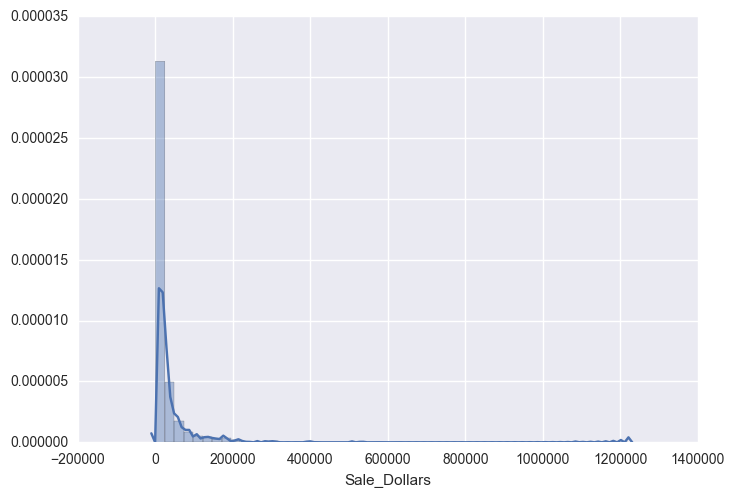

In [12]:
sns.distplot(df_10.groupby('Store_Number').Sale_Dollars.sum())
plt.show()

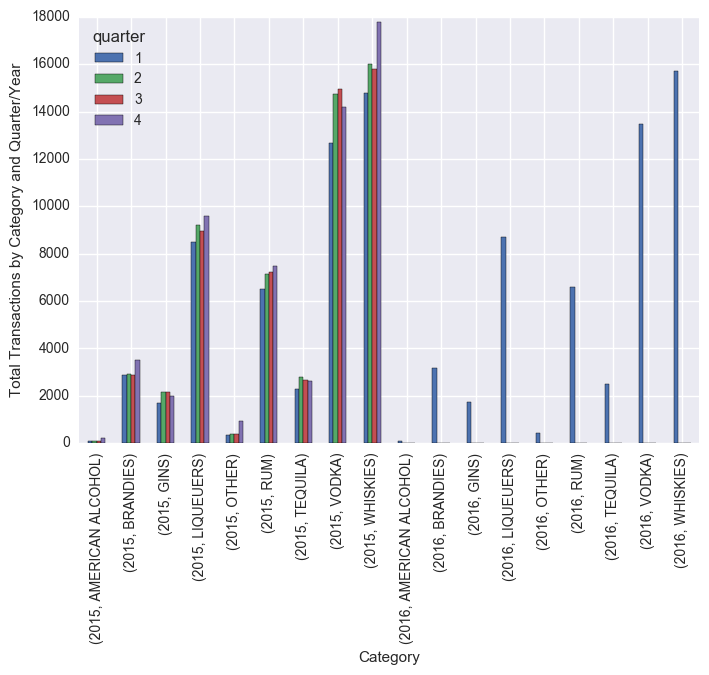

In [13]:
df_10.groupby(['quarter','year']).Cat_New.value_counts().unstack(level=0).plot(kind='bar', legend=True)
plt.xlabel('Category')
plt.ylabel('Total Transactions by Category and Quarter/Year')
plt.show()

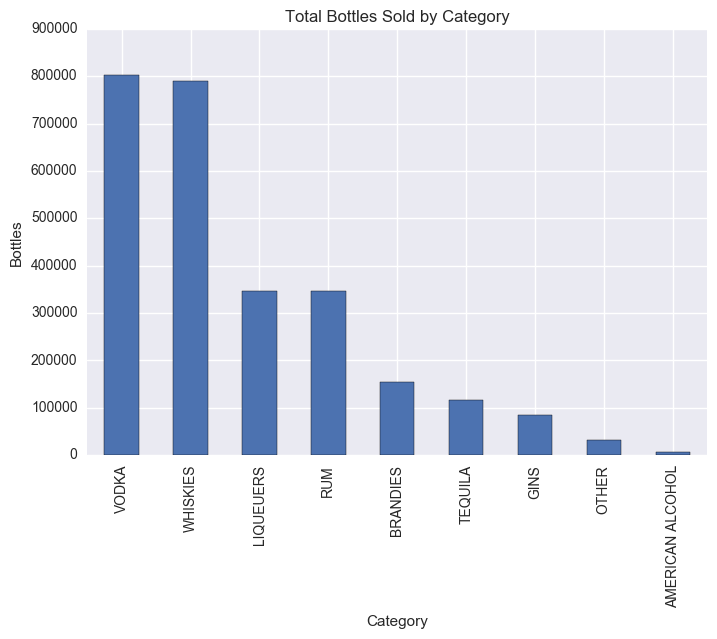

In [14]:
df_10.groupby('Cat_New').Bottles_Sold.sum().sort_values(ascending = False).plot(kind='bar')
plt.title('Total Bottles Sold by Category')
plt.xlabel('Category')
plt.ylabel('Bottles')
plt.show()

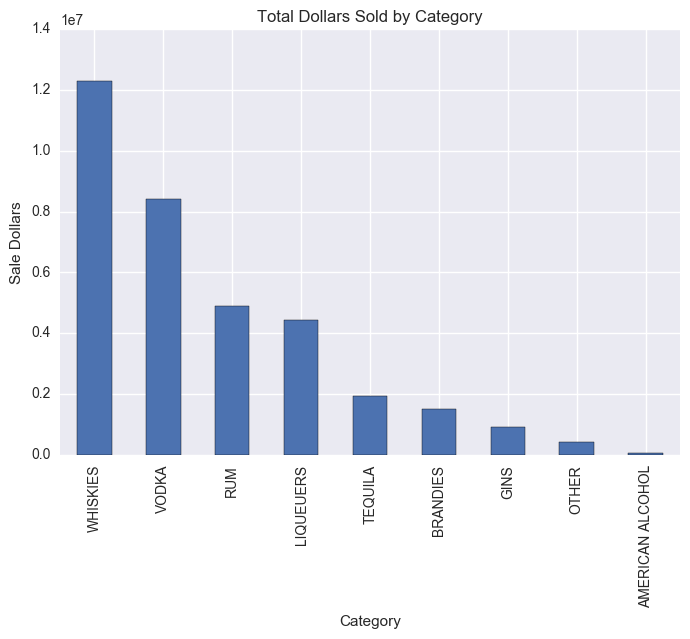

In [15]:
df_10.groupby('Cat_New').Sale_Dollars.sum().sort_values(ascending = False).plot(kind='bar')
plt.title('Total Dollars Sold by Category')
plt.xlabel('Category')
plt.ylabel('Sale Dollars')
plt.show()

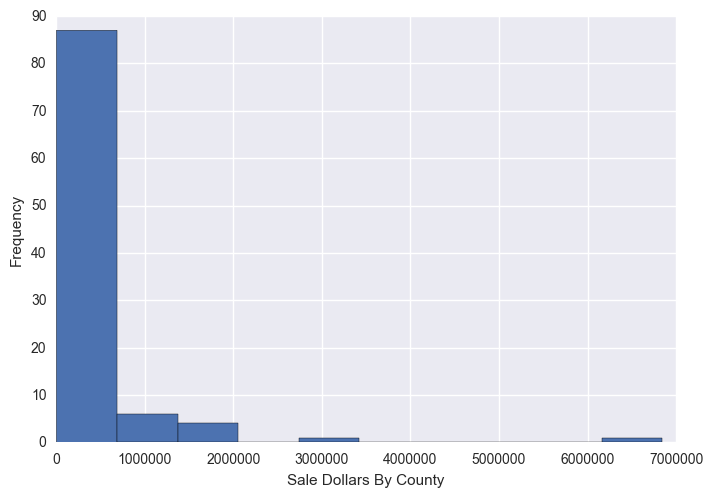

In [16]:
df_10.groupby('County').Sale_Dollars.sum().plot(kind="hist")
plt.xlabel('Sale Dollars By County')
plt.show()

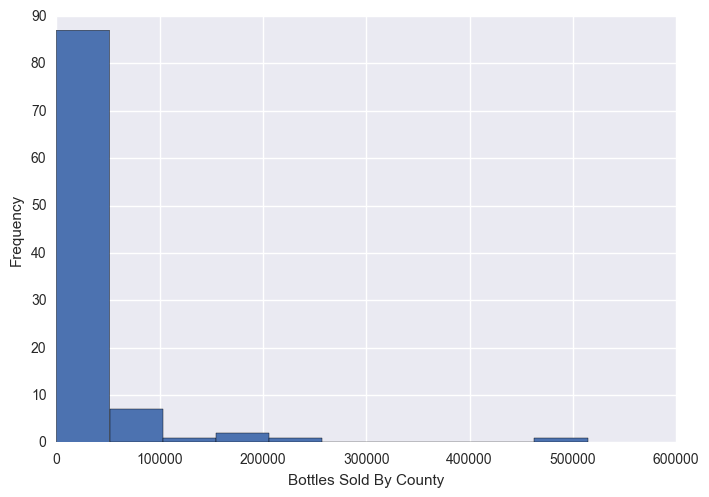

In [17]:
df_10.groupby('County').Bottles_Sold.sum().plot(kind="hist")
plt.xlabel('Bottles Sold By County')
plt.show()

The next step is to remove all columns that are not needed., and make transformations to get metrics that are more useful.

In [32]:
# Getting column of profit per bottle per transaction

new_df['Bottle_Profit'] = new_df.State_Bottle_Retail - new_df.State_Bottle_Cost

## Counts of stores by county

store_count_county = pd.DataFrame(new_df.groupby('County').Store_Number.nunique()).reset_index()
store_count_county.rename(columns= {'Store_Number':'Stores'}, inplace = True)

## Merging county pop data

county_df = pd.merge(new_df, county_data, on = 'County', how = 'left')

county_df.drop(['City','FIPS','Primary County Coordinates','Year'], axis=1, inplace = True)

## Merge df with all data, counts of stores by county

county_df2 = pd.merge(county_df, store_count_county, how = 'left', on = 'County')

## Stores per capita by county

county_df2['Stores_Capita'] = county_df2.Estimate / county_df2.Stores

## Uses profit from retail - cost to calculate profit per entire sale

county_df2['Sale_Profit'] = county_df2.Bottles_Sold * county_df2.Bottle_Profit

The next step is to finalize the features needed to create a model to predict average total store profit by county for a time period, given the average number of bottles sold of each type of liquor by each store in that county during that time period. These counts of bottles sold are normalized by dividing the counts by the number of people in the county.

In [101]:
store_profit_q1_15 = county_df2[(county_df2.quarter == 1) & (county_df2.year == 2015)].groupby(['County','Store_Number']).Sale_Profit.sum().reset_index()

Q1_15_y = store_profit_q1_15.groupby('County').Sale_Profit.mean().reset_index()

In [49]:
store_profit_q234_15 = county_df2[(county_df2.quarter != 1) & (county_df2.year == 2015)].groupby(['County','Store_Number']).Sale_Profit.sum().reset_index()

Q234_15_y = store_profit_q234_15.groupby('County').Sale_Profit.mean().reset_index()

In [67]:
test_cnty = county_df2[['Store_Number','quarter','year','County','Cat_New','Bottles_Sold','Estimate','Stores','Stores_Capita','Sale_Profit']]

In [148]:
cnty_val_X_train = test_cnty.loc[(test_cnty.quarter == 1) & (test_cnty.year == 2015)]

cnty_val_X_train = pd.pivot_table(cnty_val_X_train, values='Bottles_Sold', index=['Store_Number','County','Stores_Capita'], 
                        columns=['Cat_New'], aggfunc=np.sum).reset_index()

cnty_bottle_typ_X_train = cnty_val_X_train.groupby(['County','Stores_Capita']).mean().reset_index().drop('Store_Number'
                                                                                         , axis = 1).fillna(0)

pop_norm_bottle_typ_X_train = cnty_bottle_typ_X_train[['AMERICAN ALCOHOL','BRANDIES','GINS','LIQUEUERS','OTHER',
                 'RUM','TEQUILA','VODKA','WHISKIES']].divide(cnty_bottle_typ_X_train['Stores_Capita'], axis = 'index')

In [149]:
cnty_val_X_test = test_cnty.loc[(test_cnty.quarter != 1) & (test_cnty.year == 2015)]

cnty_val_X_test = pd.pivot_table(cnty_val_X_test, values='Bottles_Sold', index=['Store_Number','County','Stores_Capita'], 
                        columns=['Cat_New'], aggfunc=np.sum).reset_index()

cnty_bottle_typ_X_test = cnty_val_X_train.groupby(['County','Stores_Capita']).mean().reset_index().drop('Store_Number'
                                                                                         , axis = 1).fillna(0)

pop_norm_bottle_typ_X_test = cnty_bottle_typ_X_test[['AMERICAN ALCOHOL','BRANDIES','GINS','LIQUEUERS','OTHER',
                 'RUM','TEQUILA','VODKA','WHISKIES']].divide(cnty_bottle_typ_X_test['Stores_Capita'], axis = 'index')

Now that those features are finalized above, we can start to build a model.

In [150]:
X_train = pop_norm_bottle_typ_X_train
y_train = Q1_15_y.Sale_Profit

linreg = LinearRegression()

linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [151]:
X_test = pop_norm_bottle_typ_X_test
y_test = Q234_15_y.Sale_Profit

linreg.score(X_test, y_test)

-1.3171246412126743

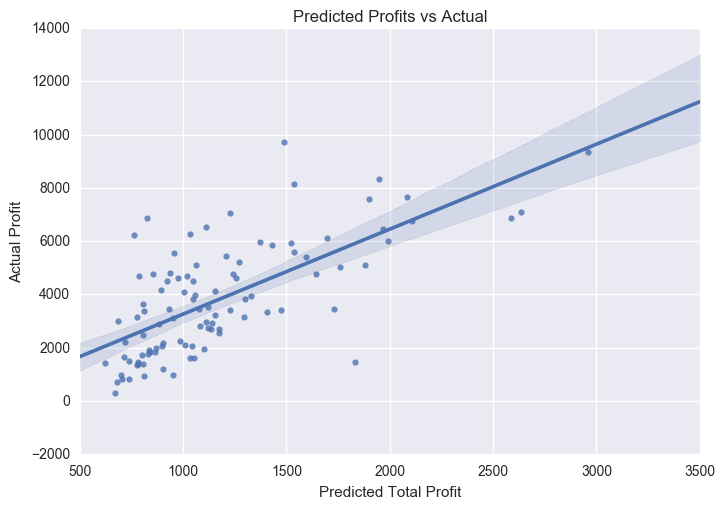

In [152]:
sns.regplot(predictions, y_test)
plt.title('Predicted Profits vs Actual')
plt.xlabel('Predicted Total Profit')
plt.ylabel('Actual Profit')
plt.show()

The model score is less than ideal, but we will continue to predict 2016 sales using it and attempt to determine the best county to open a store based on the profit that can be expected for an average store in the county, after accounting for the number of people living there.

In [153]:
predict_2016 = test_cnty.loc[(test_cnty.quarter == 1) & (test_cnty.year == 2015)]

predict_2016 = pd.pivot_table(predict_2016, values='Bottles_Sold', index=['Store_Number','County','Stores_Capita'], 
                        columns=['Cat_New'], aggfunc=np.sum).reset_index()

predict_2016_X = predict_2016.groupby(['County','Stores_Capita']).mean().reset_index().drop('Store_Number'
                                                                                         , axis = 1).fillna(0)

predict_2016_X_final = predict_2016_X[['AMERICAN ALCOHOL','BRANDIES','GINS','LIQUEUERS','OTHER',
                 'RUM','TEQUILA','VODKA','WHISKIES']].divide(predict_2016_X['Stores_Capita'], axis = 'index')

In [157]:
pd.DataFrame(zip(np.sort(test_cnty.County.unique()), linreg.predict(predict_2016_X_final)), 
             columns = ['County', 'Avg_Pred_Profits']).sort_values('Avg_Pred_Profits', ascending = False).head()

,County,Avg_Pred_Profits
76,POLK,2958.488163
13,CARROLL,2632.776122
56,LINN,2584.556291
96,WOODBURY,2108.569409
16,CERRO GORDO,2082.050826


The model created predicts that the most profitable counties for the remainder of 2016 will be Polk, Carroll, Linn, Woodbury, and Cerro Gordo counties.